#**Proyecto final**

Se realiza un modelo de regresión lineal para predecir el precio de un automóvil usado


Datos a analizar

|ID|Feature name|Feature description|
|:--|:--|:--|
|1|**Car_Name**| Nombre del auto |
|2|**Year**| Año de fabricación |
|3|**Selling_Price**| Precio de venta |
|4|**Present_Price**| Precio actual |
|5|**Kms_Driven**| Distancia recorrida por el auto (en KMs) |
|6|**Fuel_Type**| Tipo de combustible |
|7|**Seller_Type**| Tipo de vendedor |
|8|**Transmission**| Tipo de transmisión del auto |
|9|**Owner**| Numero de dueños |

Instalación de pyspark

In [9]:
!pip install -q pyspark
!pip install -q handyspark

Importando librerias

In [16]:
from pyspark import SparkContext                                    
from pyspark.sql import SparkSession, Window, Row                   
from pyspark.sql import functions as F                             
from pyspark.sql.functions import col, isnan, when, count           
from pyspark.sql.functions import *                                 
from pyspark.sql.types import *                                     

import matplotlib.pyplot as plt                                     
%matplotlib inline                                                  
import seaborn as sns                                               
from handyspark import *                                            

from pyspark.ml.feature import VectorAssembler                      
from pyspark.ml.regression import LinearRegression                  

import warnings                                                     
warnings.filterwarnings("ignore")                                   


Inciando sesión de Spark

In [17]:
spark = SparkSession.builder.appName("carsSpark").getOrCreate()
spark

Lectura de datos

In [19]:
# Lectura de archivo
df = spark.read.csv('car_data.csv', header=True, inferSchema="true")

# Tamaño del df
print('Shape of the dataset: ', (df.count(), len(df.columns)))

# Mostrando las primeras 10 filas
df.show(n=10)

Shape of the dataset:  (301, 9)
+-------------+----+-------------+-------------+----------+---------+-----------+------------+-----+
|     Car_Name|Year|Selling_Price|Present_Price|Kms_Driven|Fuel_Type|Seller_Type|Transmission|Owner|
+-------------+----+-------------+-------------+----------+---------+-----------+------------+-----+
|         ritz|2014|         3.35|         5.59|     27000|   Petrol|     Dealer|      Manual|    0|
|          sx4|2013|         4.75|         9.54|     43000|   Diesel|     Dealer|      Manual|    0|
|         ciaz|2017|         7.25|         9.85|      6900|   Petrol|     Dealer|      Manual|    0|
|      wagon r|2011|         2.85|         4.15|      5200|   Petrol|     Dealer|      Manual|    0|
|        swift|2014|          4.6|         6.87|     42450|   Diesel|     Dealer|      Manual|    0|
|vitara brezza|2018|         9.25|         9.83|      2071|   Diesel|     Dealer|      Manual|    0|
|         ciaz|2015|         6.75|         8.12|     18796|

Estadística de los datos

In [20]:
df.describe().show()

+-------+--------+------------------+-----------------+-----------------+-----------------+---------+-----------+------------+-------------------+
|summary|Car_Name|              Year|    Selling_Price|    Present_Price|       Kms_Driven|Fuel_Type|Seller_Type|Transmission|              Owner|
+-------+--------+------------------+-----------------+-----------------+-----------------+---------+-----------+------------+-------------------+
|  count|     301|               301|              301|              301|              301|      301|        301|         301|                301|
|   mean|   800.0|2013.6279069767443|4.661295681063127|7.628471760797344|36947.20598006644|     null|       null|        null|0.04318936877076412|
| stddev|    null|2.8915541273367253|5.082811556177805|8.644115402015789|38886.88388206789|     null|       null|        null| 0.2479148926949198|
|    min|     800|              2003|              0.1|             0.32|              500|      CNG|     Dealer|   Au

Información de las columnas

In [ ]:
df.printSchema()   

root
 |-- Car_Name: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Selling_Price: double (nullable = true)
 |-- Present_Price: double (nullable = true)
 |-- Kms_Driven: integer (nullable = true)
 |-- Fuel_Type: string (nullable = true)
 |-- Seller_Type: string (nullable = true)
 |-- Transmission: string (nullable = true)
 |-- Owner: integer (nullable = true)



Corroborando el tipo de datos

In [21]:
print(type(df))
print(type(df.select('Selling_Price')))

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>


Encontrando valores nulos

In [22]:
# Creating a dataframe to check null value counts
null_df = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '') | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns])

# Displaying the null value counts dataframe
null_df.show()

+--------+----+-------------+-------------+----------+---------+-----------+------------+-----+
|Car_Name|Year|Selling_Price|Present_Price|Kms_Driven|Fuel_Type|Seller_Type|Transmission|Owner|
+--------+----+-------------+-------------+----------+---------+-----------+------------+-----+
|       0|   0|            0|            0|         0|        0|          0|           0|    0|
+--------+----+-------------+-------------+----------+---------+-----------+------------+-----+



Convertimos de string a date el año y posteriormente a timestamp para mejor manipulación

In [24]:
df1 = df.withColumn("Year", F.to_date(F.col("Year").cast("string"), 'yyyy'))

df = df1.withColumn('Year', F.year(F.to_timestamp('Year', 'yyyy')))
df.show()

+-------------+----+-------------+-------------+----------+---------+-----------+------------+-----+
|     Car_Name|Year|Selling_Price|Present_Price|Kms_Driven|Fuel_Type|Seller_Type|Transmission|Owner|
+-------------+----+-------------+-------------+----------+---------+-----------+------------+-----+
|         ritz|2014|         3.35|         5.59|     27000|   Petrol|     Dealer|      Manual|    0|
|          sx4|2013|         4.75|         9.54|     43000|   Diesel|     Dealer|      Manual|    0|
|         ciaz|2017|         7.25|         9.85|      6900|   Petrol|     Dealer|      Manual|    0|
|      wagon r|2011|         2.85|         4.15|      5200|   Petrol|     Dealer|      Manual|    0|
|        swift|2014|          4.6|         6.87|     42450|   Diesel|     Dealer|      Manual|    0|
|vitara brezza|2018|         9.25|         9.83|      2071|   Diesel|     Dealer|      Manual|    0|
|         ciaz|2015|         6.75|         8.12|     18796|   Petrol|     Dealer|      Manu

Convertimos el pyspark df a handyspark df para visualización con pandas

In [25]:
hdf = df.toHandy()
hdf.show()

+-------------+----+-------------+-------------+----------+---------+-----------+------------+-----+
|     Car_Name|Year|Selling_Price|Present_Price|Kms_Driven|Fuel_Type|Seller_Type|Transmission|Owner|
+-------------+----+-------------+-------------+----------+---------+-----------+------------+-----+
|         ritz|2014|         3.35|         5.59|     27000|   Petrol|     Dealer|      Manual|    0|
|          sx4|2013|         4.75|         9.54|     43000|   Diesel|     Dealer|      Manual|    0|
|         ciaz|2017|         7.25|         9.85|      6900|   Petrol|     Dealer|      Manual|    0|
|      wagon r|2011|         2.85|         4.15|      5200|   Petrol|     Dealer|      Manual|    0|
|        swift|2014|          4.6|         6.87|     42450|   Diesel|     Dealer|      Manual|    0|
|vitara brezza|2018|         9.25|         9.83|      2071|   Diesel|     Dealer|      Manual|    0|
|         ciaz|2015|         6.75|         8.12|     18796|   Petrol|     Dealer|      Manu

Análisis de correlaciones


INFO: Safety is ON - returning up to 1000 instances.


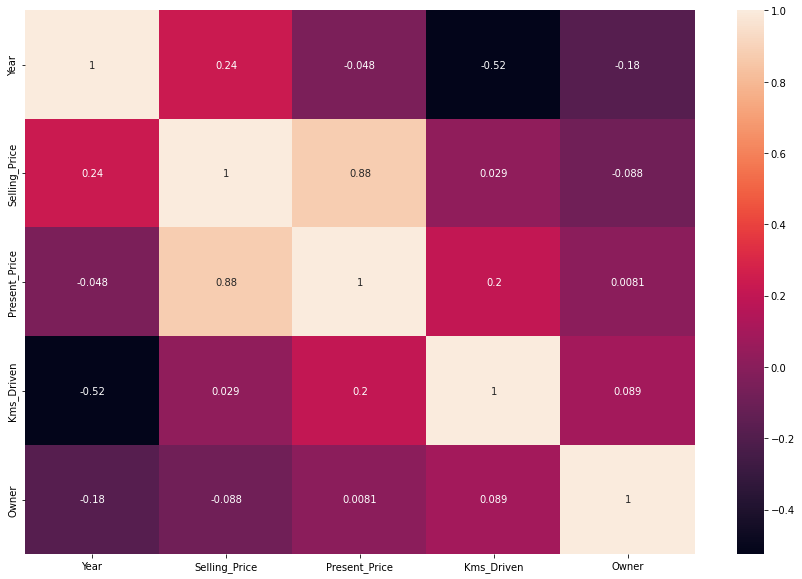

In [27]:
data = hdf.toPandas()
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True)
plt.show()

Selling_Price esta altamente correlacionada con Present_Price
Kms_driven y year estan inversamente correlacionados

VectorAssamble para transformar los datos a un vector columna

In [28]:
featureassembler = VectorAssembler(inputCols=['Year', 'Present_Price', 'Kms_Driven', 'Owner'], outputCol='Independent')


In [29]:
output = featureassembler.transform(df)
output.show()

+-------------+----+-------------+-------------+----------+---------+-----------+------------+-----+--------------------+
|     Car_Name|Year|Selling_Price|Present_Price|Kms_Driven|Fuel_Type|Seller_Type|Transmission|Owner|         Independent|
+-------------+----+-------------+-------------+----------+---------+-----------+------------+-----+--------------------+
|         ritz|2014|         3.35|         5.59|     27000|   Petrol|     Dealer|      Manual|    0|[2014.0,5.59,2700...|
|          sx4|2013|         4.75|         9.54|     43000|   Diesel|     Dealer|      Manual|    0|[2013.0,9.54,4300...|
|         ciaz|2017|         7.25|         9.85|      6900|   Petrol|     Dealer|      Manual|    0|[2017.0,9.85,6900...|
|      wagon r|2011|         2.85|         4.15|      5200|   Petrol|     Dealer|      Manual|    0|[2011.0,4.15,5200...|
|        swift|2014|          4.6|         6.87|     42450|   Diesel|     Dealer|      Manual|    0|[2014.0,6.87,4245...|
|vitara brezza|2018|    

Extraemos las características 

In [30]:
final_data = output.select("Independent", "Selling_Price")
final_data.show()

+--------------------+-------------+
|         Independent|Selling_Price|
+--------------------+-------------+
|[2014.0,5.59,2700...|         3.35|
|[2013.0,9.54,4300...|         4.75|
|[2017.0,9.85,6900...|         7.25|
|[2011.0,4.15,5200...|         2.85|
|[2014.0,6.87,4245...|          4.6|
|[2018.0,9.83,2071...|         9.25|
|[2015.0,8.12,1879...|         6.75|
|[2015.0,8.61,3342...|          6.5|
|[2016.0,8.89,2027...|         8.75|
|[2015.0,8.92,4236...|         7.45|
|[2017.0,3.6,2135....|         2.85|
|[2015.0,10.38,510...|         6.85|
|[2015.0,9.94,1500...|          7.5|
|[2015.0,7.71,2600...|          6.1|
|[2009.0,7.21,7742...|         2.25|
|[2016.0,10.79,430...|         7.75|
|[2015.0,10.79,416...|         7.25|
|[2016.0,10.79,430...|         7.75|
|[2015.0,5.09,3550...|         3.25|
|[2010.0,7.98,4144...|         2.65|
+--------------------+-------------+
only showing top 20 rows



Creamos el set de entrenamiento y el set de pruebas

In [31]:
train_data, test_data = final_data.randomSplit(weights=[0.75,0.25], seed=42)

Inicialización y entrenamiento del modelo

In [32]:
ss = LinearRegression(featuresCol='Independent', labelCol='Selling_Price')
ss = ss.fit(train_data)

Evaluación en el set de prueba

In [33]:
pred = ss.evaluate(test_data)
pred.predictions.show()

+--------------------+-------------+--------------------+
|         Independent|Selling_Price|          prediction|
+--------------------+-------------+--------------------+
|[2004.0,12.35,135...|          1.5|  2.3625707415187662|
|[2005.0,13.7,7500...|         3.51|   4.131049121599517|
|[2006.0,4.15,6500...|         1.05|-0.40172096394360324|
|[2006.0,7.6,50456...|          2.1|  1.5776887669329653|
|[2008.0,0.52,5000...|         0.17|  -6.465321294491446|
|[2008.0,22.78,890...|          4.0|   9.887276858135237|
|[2009.0,11.0,8793...|         3.35|   4.080334117625853|
|[2010.0,0.95,2700...|         0.45|-0.14040274162164224|
|[2010.0,1.05,2130...|         0.31|  -2.187945872126079|
|[2010.0,6.79,5800...|         3.25|  1.5140851543985718|
|[2010.0,7.98,4144...|         2.65|   3.395310650985607|
|[2010.0,9.9,38000...|         3.25|   4.444368091381762|
|[2011.0,0.787,750...|         0.38| -0.3891627287642905|
|[2011.0,1.05,3000...|         0.35|  0.2573152866507371|
|[2011.0,1.5,6

In [36]:
pred_train = ss.evaluate(train_data)
pred_train.predictions.show()

+--------------------+-------------+--------------------+
|         Independent|Selling_Price|          prediction|
+--------------------+-------------+--------------------+
|[2003.0,2.28,1270...|         0.35| -3.2225914491643834|
|[2003.0,7.98,6200...|         2.25|  0.5103456859753805|
|[2005.0,0.57,5500...|          0.2|  -2.551376055881178|
|[2005.0,10.21,900...|         2.75|  2.1254449253769963|
|[2005.0,13.46,197...|         3.49|   2.625265150623136|
|[2006.0,0.75,9223...|          0.1| -2.4980972177518197|
|[2006.0,23.73,142...|          2.5|   5.826254583537548|
|[2007.0,0.58,5300...|         0.12| -1.7655776896285715|
|[2007.0,0.75,4900...|          0.2|  -2.699125798300315|
|[2008.0,0.58,1900...|         0.25| -0.8096216706470614|
|[2008.0,0.75,2600...|         0.25|  -2.060451617288777|
|[2008.0,0.75,6000...|          0.2| -1.3761943739968956|
|[2008.0,0.787,500...|          0.2| -1.2438154223618767|
|[2008.0,7.15,5800...|         1.95|   2.013698756681947|
|[2009.0,1.75,

Actual vs precios predecidos

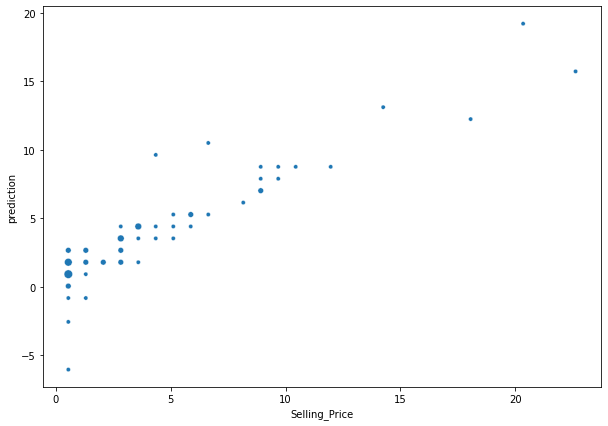

In [ ]:
pred_hdf = pred.predictions.toHandy()
fig, ax = plt.subplots(figsize=(10, 7))
pred_hdf.cols[['Selling_Price', 'prediction']].scatterplot(ax=ax)
plt.show()

Scores

In [37]:
print('RMSE for train set:', pred_train.rootMeanSquaredError)
print('RMSE for test set:', pred.rootMeanSquaredError)

RMSE for train set: 1.9702166887296308
RMSE for test set: 2.020857083342057


In [38]:
print('MSE for train set:', pred_train.meanSquaredError)
print('MSE for test set:', pred.meanSquaredError)

MSE for train set: 3.8817538005487515
MSE for test set: 4.083863351293766


In [39]:
print('R2-Score for train set:', pred_train.r2)
print('R2-Score for test set:', pred.r2)

R2-Score for train set: 0.8515799987327323
R2-Score for test set: 0.8308412358811239
